In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight

In [25]:
IMAGE_SIZE = 128
BATCH_SIZE = 16
EPOCHS = 30

TRAIN_DIR = r"D:\disease\Training"
TEST_DIR  = r"D:\disease\Testing"

CLASS_NAMES = ['glioma', 'meningioma', 'notumor', 'pituitary']
NUM_CLASSES = len(CLASS_NAMES)

In [26]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=(0.9, 1.1)
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    classes=CLASS_NAMES,
    subset='training',
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    classes=CLASS_NAMES,
    subset='validation',
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    classes=CLASS_NAMES,
    shuffle=False
)

print(train_gen.class_indices)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [15]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)

class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 1.0811258278145695, 1: 1.0659981343283582, 2: 0.8955721003134797, 3: 0.9800600343053173}


In [27]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)

class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 1.0811258278145695, 1: 1.0659981343283582, 2: 0.8955721003134797, 3: 0.9800600343053173}


In [17]:
model.compile(
    optimizer=Adam(learning_rate=3e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3),
    ModelCheckpoint("model.h5", monitor='val_loss', save_best_only=True)
]

In [20]:
x, y = next(train_gen)
print(x.shape, y[:10])
print(np.min(x), np.max(x))


(16, 128, 128, 3) [1. 3. 0. 2. 1. 1. 2. 1. 1. 0.]
0.0 1.0


In [28]:
x, y = next(train_gen)
print(x.shape, y[:8])
print(np.min(x), np.max(x), np.mean(x))

(16, 128, 128, 3) [2. 1. 1. 3. 1. 2. 1. 0.]
0.0 255.0 46.157467


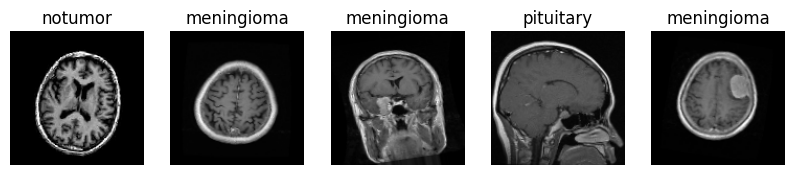

In [29]:
plt.figure(figsize=(10,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow((x[i] - x[i].min()) / (x[i].max() - x[i].min()))
    plt.title(CLASS_NAMES[int(y[i])])
    plt.axis("off")
plt.show()

In [30]:
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 128, 128, 3)          0         ['input_3[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, 128, 128, 3)          7         ['rescaling_4[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, 128, 128, 3)          0         ['normalization_2[0][0]'

In [31]:
model.compile(
    optimizer=Adam(learning_rate=3e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [32]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3),
    ModelCheckpoint("model.h5", monitor='val_loss', save_best_only=True)
]

In [33]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/30
286/286 [==============================] - ETA: 0s - loss: 0.5552 - accuracy: 0.7919

C:\Users\acer\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


286/286 [==============================] - 106s 346ms/step - loss: 0.5552 - accuracy: 0.7919 - val_loss: 0.6350 - val_accuracy: 0.7607 - lr: 3.0000e-04
Epoch 2/30
286/286 [==============================] - 97s 339ms/step - loss: 0.3820 - accuracy: 0.8670 - val_loss: 0.6440 - val_accuracy: 0.7625 - lr: 3.0000e-04
Epoch 3/30
286/286 [==============================] - 100s 349ms/step - loss: 0.3321 - accuracy: 0.8834 - val_loss: 0.5932 - val_accuracy: 0.7958 - lr: 3.0000e-04
Epoch 4/30
286/286 [==============================] - 105s 367ms/step - loss: 0.2957 - accuracy: 0.8972 - val_loss: 0.5768 - val_accuracy: 0.7914 - lr: 3.0000e-04
Epoch 5/30
286/286 [==============================] - 103s 359ms/step - loss: 0.2659 - accuracy: 0.9037 - val_loss: 0.5717 - val_accuracy: 0.8063 - lr: 3.0000e-04
Epoch 6/30
286/286 [==============================] - 101s 351ms/step - loss: 0.2472 - accuracy: 0.9101 - val_loss: 0.5370 - val_accuracy: 0.8221 - lr: 3.0000e-04
Epoch 7/30
286/286 [==============

In [34]:
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/15
286/286 [==============================] - 119s 370ms/step - loss: 0.5710 - accuracy: 0.8025 - val_loss: 0.6126 - val_accuracy: 0.7967 - lr: 1.0000e-05
Epoch 2/15
286/286 [==============================] - 102s 358ms/step - loss: 0.4147 - accuracy: 0.8521 - val_loss: 0.5864 - val_accuracy: 0.7940 - lr: 1.0000e-05
Epoch 3/15
286/286 [==============================] - 134s 470ms/step - loss: 0.3575 - accuracy: 0.8676 - val_loss: 0.5541 - val_accuracy: 0.8002 - lr: 1.0000e-05
Epoch 4/15
286/286 [==============================] - 119s 414ms/step - loss: 0.3427 - accuracy: 0.8781 - val_loss: 0.5322 - val_accuracy: 0.8221 - lr: 1.0000e-05
Epoch 5/15
286/286 [==============================] - 111s 389ms/step - loss: 0.2925 - accuracy: 0.8967 - val_loss: 0.5298 - val_accuracy: 0.8212 - lr: 1.0000e-05
Epoch 6/15
286/286 [==============================] - 118s 411ms/step - loss: 0.2970 - accuracy: 0.8963 - val_loss: 0.5022 - val_accuracy: 0.8186 - lr: 1.0000e-05
Epoch 7/15
286/286 [==

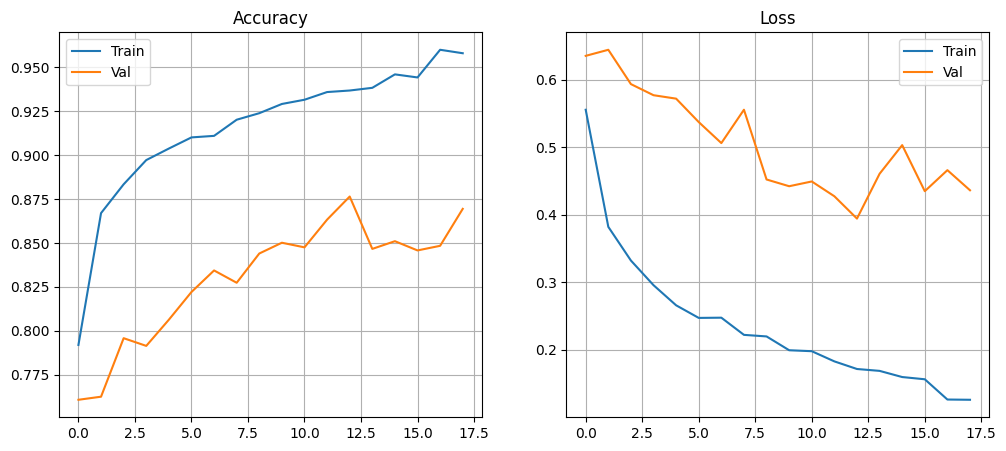

In [35]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.legend()
plt.grid(True)
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.legend()
plt.grid(True)
plt.title("Loss")

plt.show()

In [36]:
test_loss, test_acc = model.evaluate(test_gen)
print("Test Accuracy:", test_acc)

82/82 [==============================] - 29s 356ms/step - loss: 0.3776 - accuracy: 0.8764
Test Accuracy: 0.8764302134513855


In [37]:
y_true = test_gen.classes
y_probs = model.predict(test_gen)
y_pred = np.argmax(y_probs, axis=1)

82/82 [==============================] - 29s 313ms/step


In [38]:
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

      glioma       0.87      0.80      0.83       300
  meningioma       0.84      0.73      0.78       306
     notumor       0.95      0.97      0.96       405
   pituitary       0.82      0.99      0.90       300

    accuracy                           0.88      1311
   macro avg       0.87      0.87      0.87      1311
weighted avg       0.88      0.88      0.87      1311



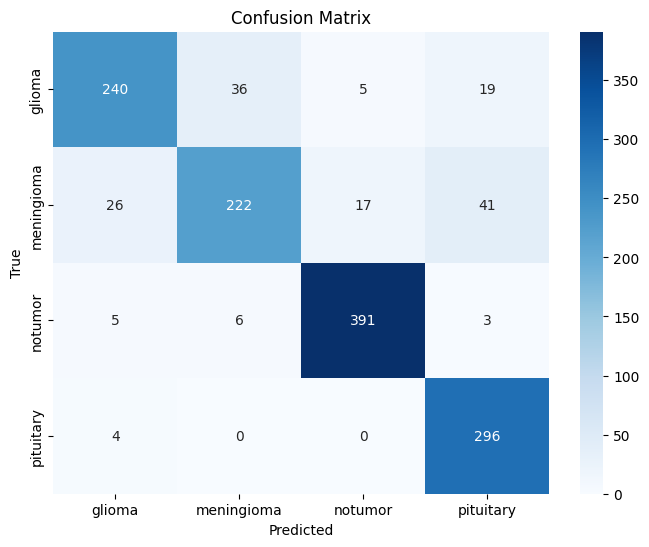

In [39]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


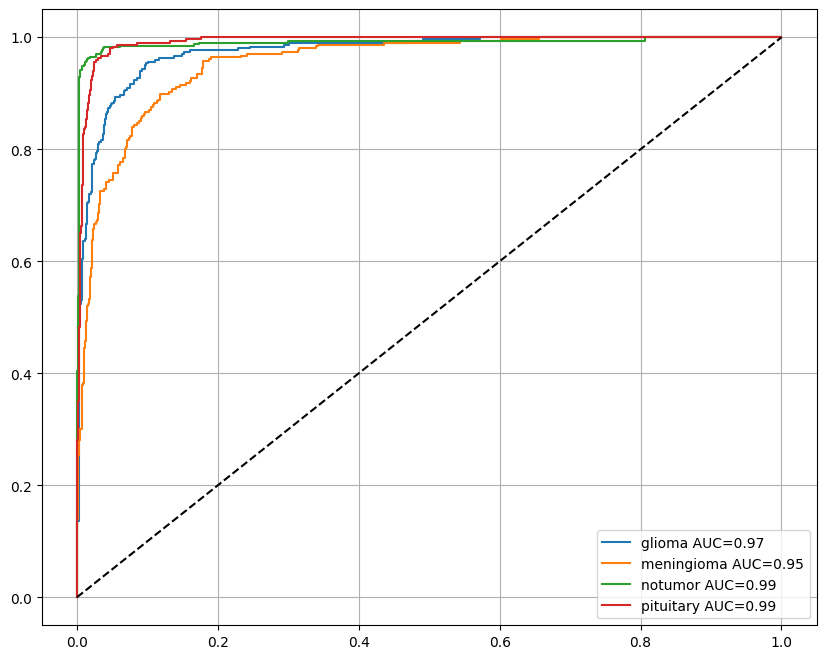

In [40]:
y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))

plt.figure(figsize=(10,8))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{CLASS_NAMES[i]} AUC={roc_auc:.2f}")

plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.grid(True)
plt.show()


In [41]:
model.save("model.h5")

C:\Users\acer\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
